# Data Inspection

This is a notebook intended to highlight some of the questions that can arise, specifically when using ITS_LIVE to study slower moving glaciers. The notebook contains a few functions designed to filter the dataset based on different characteristics. They are designed to be modular and flexible. NOTE: these are not meant to be blindly implemented, rather to provide examples of possible solutions to outlier detection problems. Feel free to use and adjust them to best fit your use-case. 

In [ ]:
#| default_exp dataset_inspection

In [ ]:
%matplotlib widget

In [ ]:
#| hide 
from nbdev.showdoc import *
import nbdev
from nbdev import nbdev_export

In [ ]:
#| export 
from ITS_LIVE_TOOL import datacube_tools, interactive, obj_setup

In [ ]:
#| export
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
import xarray as xr

## Data prep

In [ ]:
#| hide 

data_map = interactive.Widget()

In [ ]:
#| hide 

data_map.display()

In [ ]:
#| hide 

glacier = obj_setup.create_glacier_from_click(data_map, 0)

In [ ]:
#| hide 

glacier_point = obj_setup.create_glacier_point_from_click(data_map, 0, 'baltoro_near_terminus')

original xy [76.32018595385028, 35.74112031374446] 4326 maps to datacube (619376.2693730696, 3956038.9666822297) EPSG:32643
original xy [76.32018595385028, 35.74112031374446] 4326 maps to datacube (619376.2693730696, 3956038.9666822297) EPSG:32643
subset and load at  70.21 seconds


In [ ]:
#| hide 

#how many time steps:
len(glacier_point.cube_around_point.mid_date.data)

24399

In [ ]:
#| hide 

ds_full = glacier_point.cube_around_point

In [ ]:
#| hide 
len(ds.mid_date.data)

24399

In [ ]:
#| export
def swap_time_dim(ds):

    #get rid of empty time steps
    time_step_keep = list(ds.v.dropna(how='all', dim='mid_date').mid_date.data)
    ds = ds.where(ds.mid_date.isin(time_step_keep), drop=True)
    #add a numeric time dimensions
    ds['time_numeric'] = ds.mid_date.dt.year + ds.mid_date.dt.dayofyear / 365
    ds = ds.swap_dims({'mid_date':'time_numeric'})

    #add numeric versions of img date 1, 2
    ds['img1_numeric'] = ds.acquisition_date_img1.dt.year + ds.acquisition_date_img1.dt.dayofyear / 365
    ds['img2_numeric'] = ds.acquisition_date_img2.dt.year + ds.acquisition_date_img2.dt.dayofyear / 365

    #add temp baseline as a coordinate
    ds = ds.assign_coords({'img_separation': ds.img_separation})
    return ds#| export

In [ ]:
#| hide 

ds_full = swap_time_dim(ds_full)

In [ ]:
#| hide 

orig_dataset_len = len(ds_full.mid_date.data)

In [ ]:
#| hide 

orig_dataset_len

16859

## 1. Thresholding using v_error

### Description
ITS_LIVE image pair data comes with an associated velocity error variable. It is calculated by : (insert equation from docs). 

One way you may want to threshold your dataset is to use the `v_error` variable. This notebook provides an example of setting an acceptable threshold of `v_error` in relation to `v`, and excluding any observations where `v_error` exceeds this limit. 

### Pros

### Cons

```{note}
there is an issue w/ this fn, figure it out wednesday
```

In [ ]:
#| hide
def trim_by_error(ds, thresh):
    ds_keep = ds.where(ds.v*thresh >= ds.v_error, drop=True)

    #verr_keep_timesteps = list(ds_keep.mid_date.data)

    #reject = ds.where(~ds.mid_date.isin(verr_keep_timesteps), drop=True)
    #reject = ds_orig.where(~(ds_orig.v_error <= thresh*ds_orig.v), drop=True)
    #reject = ds.where(ds.v*thresh < ds.v_error, drop=True)


    #ds_baseline_rejects = ds.where(~ds.mid_date.isin(baseline_keep_timesteps), drop=True)
    print('# original: ', len(ds.time_numeric.data))
    print('# rejected: ', len(reject.time_numeric.data))
    print('# kept: ', len(ds_keep.time_numeric.data))
    return ds, reject 

In [ ]:
#| hide 

ds_verr_trim, reject = trim_by_error(ds_full, 0.5)

# original:  16859
# rejected:  726
# kept:  8424


### Visualize results

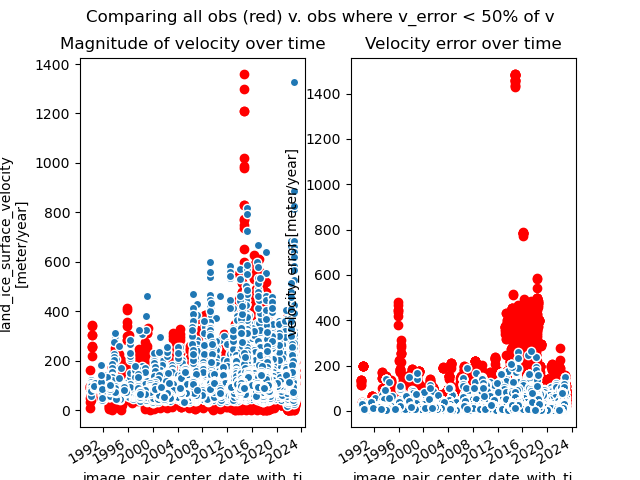

In [ ]:
#| hide 

fig, axs = plt.subplots(ncols=2)

reject['v'].plot.scatter(x='mid_date', y='v', linestyle='None', marker='o', color = 'red', ax=axs[0])
ds_trim['v'].plot.scatter(x='mid_date', y='v', linestyle='None', marker='o', ax=axs[0])

reject['v_error'].plot.scatter(x='mid_date', y='v_error', linestyle='None', marker='o', color = 'red', ax=axs[1])
ds_trim['v_error'].plot.scatter(x='mid_date', y='v_error', linestyle='None', marker='o', ax=axs[1])

axs[0].set_title('Magnitude of velocity over time')
axs[1].set_title('Velocity error over time')
fig.suptitle('Comparing all obs (red) v. obs where v_error < 50% of v');

<matplotlib.collections.PathCollection>

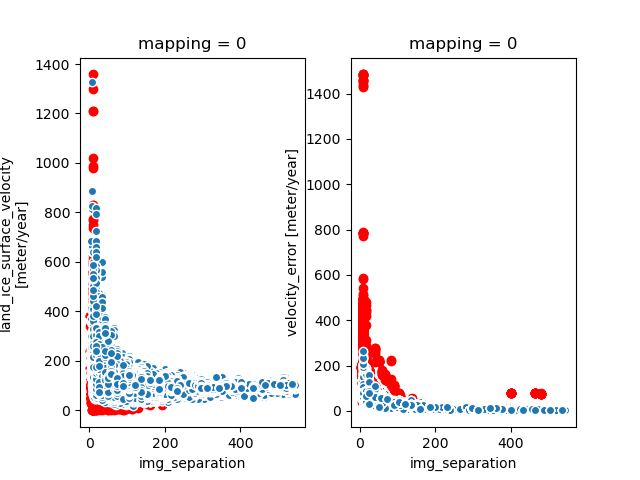

In [ ]:
#| hide 

fig, axs = plt.subplots(ncols=2)

reject['v'].plot.scatter(x='img_separation', y='v', linestyle='None', marker='o', color = 'red', ax=axs[0])
ds_trim['v'].plot.scatter(x='img_separation', y='v', linestyle='None', marker='o', ax=axs[0])

reject['v_error'].plot.scatter(x='img_separation', y='v_error', linestyle='None', marker='o', color = 'red', ax=axs[1])
ds_trim['v_error'].plot.scatter(x='img_separation', y='v_error', linestyle='None', marker='o', ax=axs[1])

In [ ]:
#| hide 

print(f'Original dataset length: {orig_dataset_len}, length of dataset trimmed using v_error: {len(ds_trim.mid_date.data)}')

Original dataset length: 16859, length of dataset trimmed using v_error: 8424


In [ ]:
#| hide 

# issue in above not being exlucded / counted correctly

#### Visualizing just the excluded datasets 



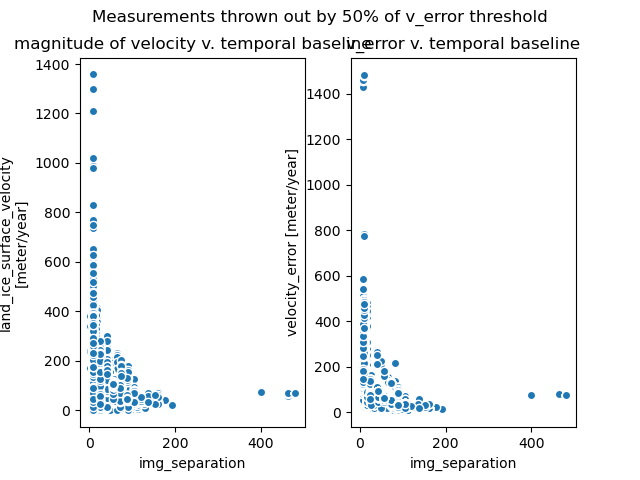

In [ ]:
#| hide 

fig, axs = plt.subplots(ncols=2)

reject.plot.scatter(x='img_separation', y='v',ax=axs[0])
reject.plot.scatter(x='img_separation', y='v_error',ax=axs[1])

axs[0].set_title('magnitude of velocity v. temporal baseline')
axs[1].set_title('v_error v. temporal baseline')
fig.suptitle('Measurements thrown out by 50% of v_error threshold');

## 2. Thresholding via min temp baseline threshold

### Description:
-add a citation for nyquist principle
This method considers the expected ice movement of the selected point on the glacier based on long-term movement at this location and compares this value to the ground sampling distance of the imaging sensor to determine the minimum temporal baseline that would be needed to capture expected ice movement. To accomplish this, we take only the observations measured from image pairs where the temporal baseline is greater than 365 days. We then calculate the median velocity of all of these observations and use this as the expected displacement value.
  To calculate the minimum temporal baseline, we consider the expected displacement and the Nyquist Principle which states that sampling frequency must be at least twice the expected frequency of the data variability (rewrite) to avoid artifacts related to aliasing and other sampling distortions. 
  The resulting dataset has a calculated minimum temporal baseline for each imaging sensor that contributes to the dataset. Due to the approximate nature of this approach and in order to minimize erroneously excluded observations we do not include a term related to the performance of the chip correlation algorithm, though this is another source of error that would increase the minimum temporal baseline over which ice displacement could be confidently detected. 

### Pros
- physical basis. This approach is rooted in limitations of the satellite imaging sensors used and the long-term record of long temporal baseline velocity estimates which are typically characterized by less noise and higher confidence than shorter temporal baseline pairs. 
### Cons
- potentially very overly-conservative. We are basing the expected ice movement on a long-term median velocity value. If shorter-term velocity velocity variability is significantly faster than this long-term, expected value than these observations may be incorrectly excluded.
- Needs to be applied carefully if your analysis will include a spatial dimension. Put differently, this method in its current form would be inappropriate if it is separately calculated for each point included in analysis because it would create the situation where ice velocity estimates derived from different length image pairs are being compared. 

### Find long-term speed at this point

In [ ]:
#| export
def find_longterm_median_v(ds):

    ds_long = ds.where(ds.img_separation >= 365, drop=True)

    med_v = ds_long.v.median(dim=['x','y','time_numeric']).data
    print(med_v)
    return med_v, ds_long

In [ ]:
#| hide 

ds_long = find_longterm_median_v(ds)[1]

99.0


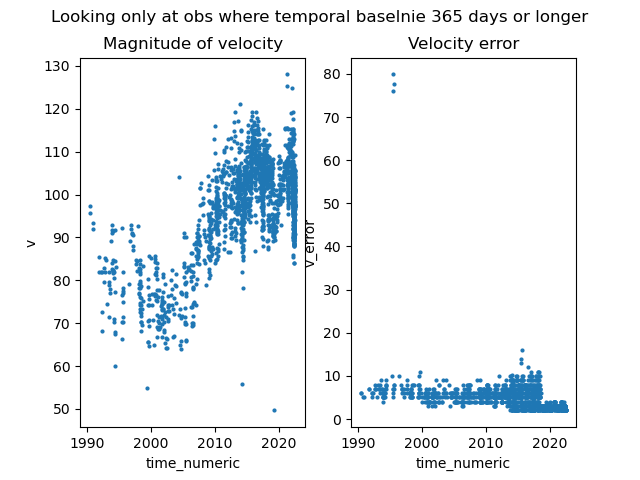

In [ ]:
#| hide 

fig,ax = plt.subplots(ncols=2)

ds_long.v.mean(dim=['x','y']).plot(linestyle='None', marker='o',ax=ax[0],markersize=2)
ds_long.v_error.mean(dim=['x','y']).plot(linestyle='None', marker='o', markersize=2,ax=ax[1])

ax[0].set_title('Magnitude of velocity')
ax[1].set_title('Velocity error')
fig.suptitle('Looking only at obs where temporal baselnie 365 days or longer');

In [ ]:
#| export
def calc_min_tbaseline(ds):

    med_v = find_longterm_median_v(ds)[0]
    gsd_l5, gsd_l7, gsd_s2, gsd_l8, gsd_s1, gsd_l9 = 30, 15, 10, 15, 10, 15
    name_ls = ['L5','L7', 'S2','L8','S1', 'L9']
    gsd_ls = [gsd_l5, gsd_l7, gsd_s2, gsd_l8, gsd_s1, gsd_l9]
    sensor_str_ls = ['5','7',['2A','2B'], '8',['1A','1B'],'9']
    min_tb_ls = []
    for element in range(len(gsd_ls)):
        min_tb = ((gsd_ls[element]*2)/med_v)*365
        min_tb_ls.append(min_tb)
        #print(min_tb, ' days')

    min_tb_dict= {'sensor':name_ls, 
                  'gsd': gsd_ls, 
                  'min_tb (days)': min_tb_ls,
                 'sensor_str':sensor_str_ls}
    df = pd.DataFrame(min_tb_dict)
    return df

In [ ]:
#| export
def trim_by_baseline(ds):

    min_tb_df = calc_min_tbaseline(ds)

    l5 = ds.where(ds.satellite_img1 == '5', drop=True)
    l7 = ds.where(ds.satellite_img1 == '7', drop=True)
    l8 = ds.where(ds.satellite_img1 == '8',drop=True)
    l9 = ds.where(ds.satellite_img1 == '9',drop=True)
    s1 = ds.where(ds.satellite_img1.isin(['1A','1B']),drop=True)
    s2 = ds.where(ds.satellite_img1.isin(['2A','2B']),drop=True)

    l5_sub = l5.where(l5.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L5']['min_tb (days)']), drop=True)
    l7_sub = l7.where(l7.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L7']['min_tb (days)']), drop=True)
    l8_sub = l8.where(l8.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L8']['min_tb (days)']), drop=True)
    l9_sub = l9.where(l9.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'L9']['min_tb (days)']), drop=True)
    s1_sub = s1.where(s1.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'S1']['min_tb (days)']), drop=True)
    s2_sub = s2.where(s2.img_separation >= int(min_tb_df.loc[min_tb_df['sensor'] == 'S2']['min_tb (days)']), drop=True)
    ds_ls = [l5_sub, l7_sub, l8_sub, l9_sub, s1_sub, s2_sub]
    concat_ls = []
    for ds in range(len(ds_ls)):
            if len(ds_ls[ds].mid_date) > 0:
                concat_ls.append(ds_ls[ds])
    print(len(concat_ls))
    try:
        combine = xr.concat(concat_ls, dim='time_numeric')
        combine = combine.sortby(combine.mid_date)
        return combine
    except:
        print('something went wrong')

In [ ]:
#| hide 

ds_baseline_trim = trim_by_baseline(ds)

99.0
5


In [ ]:
#| hide 

ds_baseline_trim

<xarray.Dataset>
Dimensions:                (time_numeric: 12099, y: 4, x: 3)
Coordinates:
    img_separation         (time_numeric) float64 432.0 416.0 ... 76.0 76.0
    mid_date               (time_numeric) datetime64[ns] 1990-06-21T04:51:31....
  * x                      (x) float64 6.193e+05 6.194e+05 6.195e+05
  * y                      (y) float64 3.956e+06 3.956e+06 3.956e+06 3.956e+06
    mapping                int64 0
  * time_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
Data variables:
    v                      (time_numeric, y, x) float32 nan 91.0 ... 63.0 nan
    vy                     (time_numeric, y, x) float32 nan 7.0 nan ... -9.0 nan
    vx                     (time_numeric, y, x) float32 nan -90.0 ... -62.0 nan
    v_error                (time_numeric, y, x) float32 nan 6.0 nan ... 13.0 nan
    satellite_img1         (time_numeric) object '5' '5' '5' ... '2B' '2B' '2B'
    satellite_img2         (time_numeric) object '5' '5' '5' ... '2A' '2A' '2A'
    acquisition_date_img1  (time_numeric) datetime64[ns] 1989-11-17T04:53:20....
    acquisition_date_img2  (time_numeric) datetime64[ns] 1991-01-23T04:49:41....
    img1_numeric           (time_numeric) float64 1.99e+03 ... 2.023e+03
    img2_numeric           (time_numeric) float64 1.991e+03 ... 2.023e+03
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 21:40:31
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E070/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

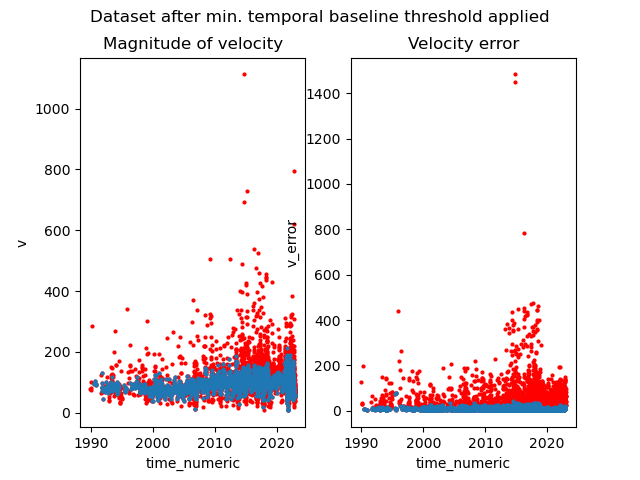

In [ ]:
#| hide 

fig,ax = plt.subplots(ncols=2)

ds.v.mean(dim=['x','y']).plot(linestyle='None', marker='o', ax=ax[0], color='red', markersize=2)
ds_baseline_trim.v.mean(dim=['x','y']).plot(linestyle='None', marker='o',ax=ax[0],markersize=2)

ds.v_error.mean(dim=['x','y']).plot(linestyle='None', marker='o', color='red',markersize=2,ax=ax[1])
ds_baseline_trim.v_error.mean(dim=['x','y']).plot(linestyle='None', marker='o', markersize=2,ax=ax[1])


ax[0].set_title('Magnitude of velocity')
ax[1].set_title('Velocity error')
fig.suptitle('Dataset after min. temporal baseline threshold applied');

In [ ]:
#| hide 

baseline_keep_timesteps = list(ds_baseline_trim.mid_date.data)
ds_baseline_rejects = ds.where(~ds.mid_date.isin(baseline_keep_timesteps), drop=True)

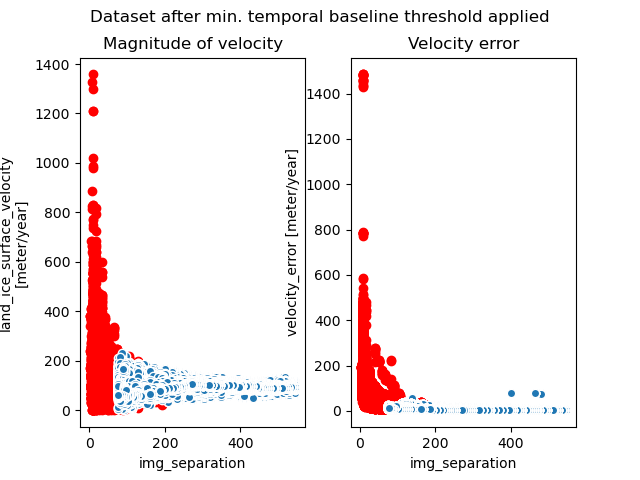

In [ ]:
#| hide 

fig,ax = plt.subplots(ncols=2)
reject.plot.scatter(x='img_separation', y='v',ax=axs[0])


ds_baseline_rejects.plot.scatter(x='img_separation',y='v',linestyle='None', marker='o', color='red', ax=ax[0])
ds_baseline_trim.plot.scatter(x='img_separation',y='v',linestyle='None', marker='o',ax=ax[0])

ds_baseline_rejects.plot.scatter(x='img_separation',y='v_error',linestyle='None', marker='o', color='red',ax=ax[1])
ds_baseline_trim.plot.scatter(x='img_separation',y='v_error',linestyle='None', marker='o',ax=ax[1])



ax[0].set_title('Magnitude of velocity')
ax[1].set_title('Velocity error')
fig.suptitle('Dataset after min. temporal baseline threshold applied');

In [ ]:
#| hide 

baseline_trim_rejects = len(ds_baseline_rejects.time_numeric.data)
baseline_trim_keeps = len(ds_baseline_trim.time_numeric.data)

In [ ]:
#| hide 

print('# baseline trim keep: ', baseline_trim_keeps)
print('# baseline trim reject: ', baseline_trim_rejects)

# baseline trim keep:  12099
# baseline trim reject:  4760


In [ ]:
#| hide 

baseline_trim_keeps+baseline_trim_rejects

16859

## 3. Blunt temporal baseline minimum for all sensors

### Pros
- Much simpler to apply at scale, across multiple points and glaciers

### Cons
- Least sensitive to the structure of the dataset
- No explicit physical basis, this method is only as effective as the choice of threshold

In [ ]:
#| hide 

ds_sub = ds.where(ds.img_separation >= 60, drop=True)

In [ ]:
#| hide 

ds_short = ds.where(ds.img_separation < 60, drop=True)

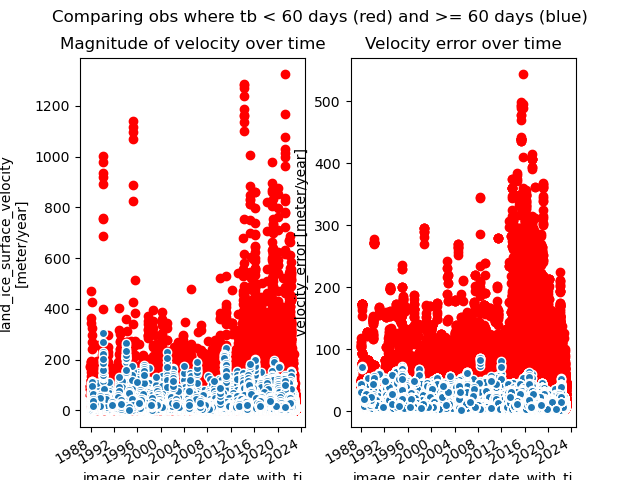

In [ ]:
#| hide 

fig, axs = plt.subplots(ncols=2)

ds_short['v'].plot.scatter(x='mid_date', y='v', linestyle='None', marker='o', color = 'red', ax=axs[0])
ds_sub['v'].plot.scatter(x='mid_date', y='v', linestyle='None', marker='o', ax=axs[0])

ds_short['v_error'].plot.scatter(x='mid_date', y='v_error', linestyle='None', marker='o', color = 'red', ax=axs[1])
ds_sub['v_error'].plot.scatter(x='mid_date', y='v_error', linestyle='None', marker='o', ax=axs[1])

axs[0].set_title('Magnitude of velocity over time')
axs[1].set_title('Velocity error over time')
fig.suptitle('Comparing obs where tb < 60 days (red) and >= 60 days (blue)');

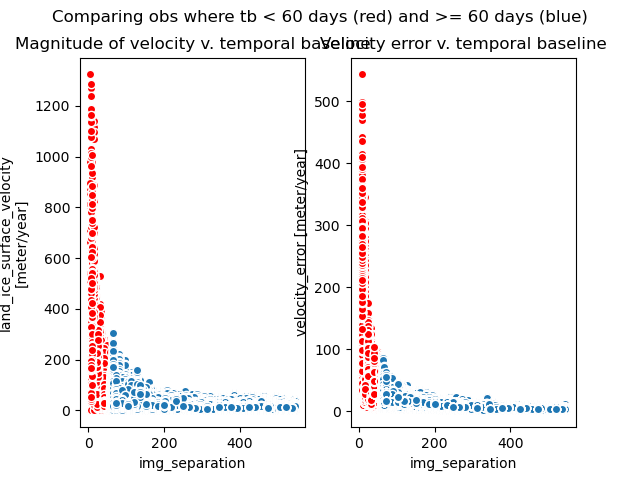

In [ ]:
#| hide 

fig, axs = plt.subplots(ncols=2)

ds_short['v'].plot.scatter(x='img_separation', y='v', linestyle='None', marker='o', color = 'red', ax=axs[0], edgecolor='white')
ds_sub['v'].plot.scatter(x='img_separation', y='v', linestyle='None', marker='o', ax=axs[0])

ds_short['v_error'].plot.scatter(x='img_separation', y='v_error', linestyle='None', marker='o', color = 'red', ax=axs[1], edgecolor='white')
ds_sub['v_error'].plot.scatter(x='img_separation', y='v_error', linestyle='None', marker='o', ax=axs[1])


axs[0].set_title('Magnitude of velocity v. temporal baseline')
axs[1].set_title('Velocity error v. temporal baseline')

fig.suptitle('Comparing obs where tb < 60 days (red) and >= 60 days (blue)');

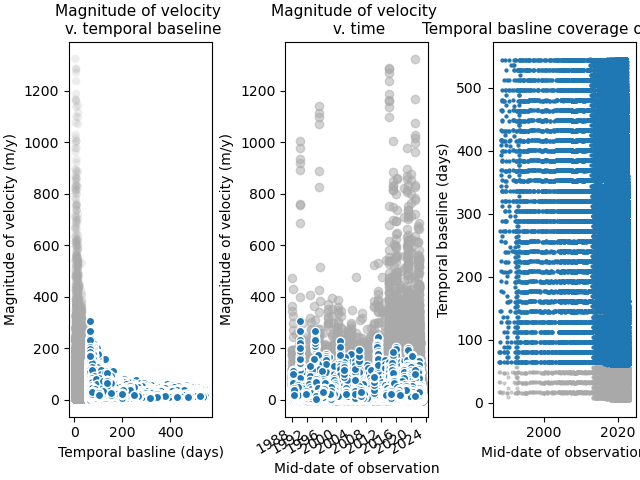

In [ ]:
#| hide 

fig, axs = plt.subplots(ncols=3, constrained_layout=True)

ds[['img_separation','v']].plot.scatter(x='img_separation',y='v', ax=axs[0], marker='o', edgecolor='None' , color='darkgrey', alpha = 0.2);
ds_sub[['img_separation','v']].plot.scatter(x='img_separation',y='v', ax=axs[0], marker='o',)

ds['v'].plot.scatter(x='mid_date', y='v', ax=axs[1], alpha=0.5, color='darkgrey')
ds_sub['v'].plot.scatter(x='mid_date', y='v', ax=axs[1])

ds.img_separation.plot(linestyle='None', marker='o', markersize=2, color='darkgrey', alpha = 0.5, ax=axs[2])
ds_sub.img_separation.plot(linestyle='None', marker='o', markersize=2, ax=axs[2])

axs[0].set_ylabel('Magnitude of velocity (m/y)')
axs[1].set_ylabel('Magnitude of velocity (m/y)')
axs[2].set_ylabel('Temporal baseline (days)')

axs[0].set_xlabel('Temporal basline (days)')
axs[1].set_xlabel('Mid-date of observation')
axs[2].set_xlabel('Mid-date of observation')

axs[0].set_title('Magnitude of velocity \n v. temporal baseline', fontsize=11)
axs[1].set_title('Magnitude of velocity \n v. time', fontsize=11)
axs[2].set_title('Temporal basline coverage over time', fontsize=11);

## Comparison to faster-flowing glacier

Recreating the above-plots for a point on a faster-moving glacier, we see a few interesting things. 

[Malaspina glacier, Alaska](https://github.com/vdevauxchupin/ITS_LIVE_TOOL/blob/main/figs/Figure%2013.png?raw=true)

## anomaly detection attempts

### 1. fit spline to points, then take 1st, 2nd derivative of interpolated spline

In [ ]:
#| hide
from sklearn import svm 
import numpy as np
import matplotlib

In [ ]:
#| hide
from scipy.interpolate import splrep, BSpline, UnivariateSpline

In [ ]:
#| hide 

df = ds[['v','v_error','img_separation','acquisition_date_img1','acquisition_date_img2']].to_dataframe().reset_index().drop(['y','x','mapping'],axis=1)

In [ ]:
#| hide 

df = df.dropna(subset='v')

In [ ]:
#| hide 

#groups = df.groupby(['team', pd.cut(df.points, [0, 10, 15, 20])])

groups = np.round(np.linspace(df['img_separation'].min(), df['img_separation'].max(), 100))

In [ ]:
#| hide 

df_resample = df.groupby( pd.cut(df['img_separation'], groups)).max()

In [ ]:
#| hide 

df_resample = df_resample.rename(columns={'img_separation':'img_separation_raw'}).reset_index()

In [ ]:
#| hide 

df_resample = df_resample.reset_index().sort_values(by='img_separation')

In [ ]:
#| hide 

verr_resample = df_resample['v_error']
v_resample = df_resample['v']
tb_resample = df_resample['img_separation_raw']

In [ ]:
#| hide 

np.min(tb_resample)
np.max(tb_resample)

tb_s = np.linspace(np.min(tb_resample), np.max(tb_resample))

#### univariate spline

In [ ]:
#| hide 

us = UnivariateSpline(tb_resample, v_resample, w=verr_resample, k=5)

In [ ]:
#| hide 

us(tb_s)

array([1286.99999963,  539.29886789,  532.88218522,  294.31350234,
        136.381293  ,  305.92986573,  143.42540743,  115.27766956,
        189.96993556,  146.57231631,  110.12704314,  161.07915577,
        121.48702667,   94.46045462,  121.49848485,   59.33224315,
         74.92636674,   75.99721401,   60.38594403,   58.1010411 ,
         63.30949607,   65.51747545,   47.54518693,   56.6737526 ,
         66.34295626,   64.96704494,   46.84685882,   55.86051953,
         42.41593975,   34.94163147,   51.62934129,   45.79115857,
         50.88941933,   54.93122788,   42.44373559,   34.52233098,
         53.71063661,   31.20241505,   42.08979996,   60.13356016,
         55.79097808,   44.88484108,   37.72695355,   38.9561851 ,
         37.05930765,   30.7123131 ,   47.00703612,   40.30393772,
         30.95040771,   42.99999487])

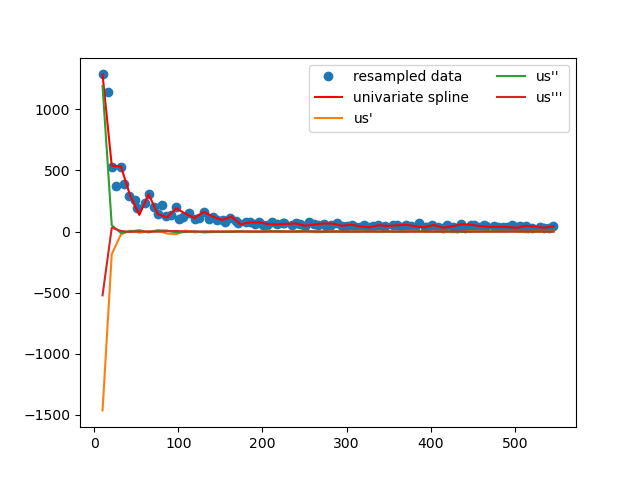

In [ ]:
#| hide 

fig, ax = plt.subplots()
ax.plot(tb_resample, v_resample, 'o', label='resampled data')
ax.plot(tb_s, us(tb_s), 'r', label = 'univariate spline')
ax.plot(tb_s, us.derivative(n=1)(tb_s), label = "us'")
ax.plot(tb_s, us.derivative(n=2)(tb_s), label = "us''")
ax.plot(tb_s, us.derivative(n=3)(tb_s), label = "us'''")
#ax.plot(tb_resample)

#ax.plot(us.derivative(n=1)(tb_s), label = "US'")
ax.legend(loc = 'upper right', ncol=2);

In [ ]:
#| hide 

us.derivative(n=1)(tb_s)

array([-1.29307403e+02, -2.15605371e+01,  3.66713392e+00,  6.77224564e+00,
       -5.99661554e+00, -6.39910901e+00,  6.27131981e+00,  1.45247995e+00,
       -8.32824590e+00,  6.18325467e-01, -7.14637994e-01, -9.38118646e-01,
        2.04563259e+00, -4.44582155e+00,  1.57252470e+00,  2.03141619e+00,
       -3.49400790e+00,  1.40181494e+00,  1.82565902e+00, -3.72416856e-01,
       -6.96107573e-01,  1.19316152e+00,  1.12476356e-01, -1.97882062e+00,
       -2.97756489e+00,  1.84165630e+00, -7.92356798e-01, -5.55542246e-01,
        1.11558092e+00, -1.23283092e-01, -4.92017685e-01,  8.46952025e-01,
       -8.56351007e-01,  5.23519403e-01,  7.16759306e-01, -2.17020070e+00,
        5.95032575e-01,  8.77924656e-01, -1.71108314e+00,  3.22610136e-01,
        2.35540678e-01,  1.22614559e+00, -2.88628996e-01, -4.85578769e-02,
        7.24917085e-01, -2.88106845e-01, -1.42277829e+00,  7.45224656e-01,
       -5.36581105e-01, -1.04425328e+00])

In [ ]:
#| hide 

tb_s.shape

(50,)

### Log transforming y data then fitting spline

In [ ]:
#| hide 

df_resample_2 = df.groupby('img_separation').max().reset_index()

In [ ]:
#| hide 

x = df_resample_2['img_separation']
y = df_resample_2['v_error']

In [ ]:
#| hide 

y_log = np.log(y)

In [ ]:
#| hide 

len(df_resample_2['img_separation'])

309

In [ ]:
#| hide 

#cs = CubicSpline(x,y)
us = UnivariateSpline(x, y, k=3)

In [ ]:
#| hide 

us_log = UnivariateSpline(x,y_log, k=3)

In [ ]:
#| hide 

x_log = np.log10(x)

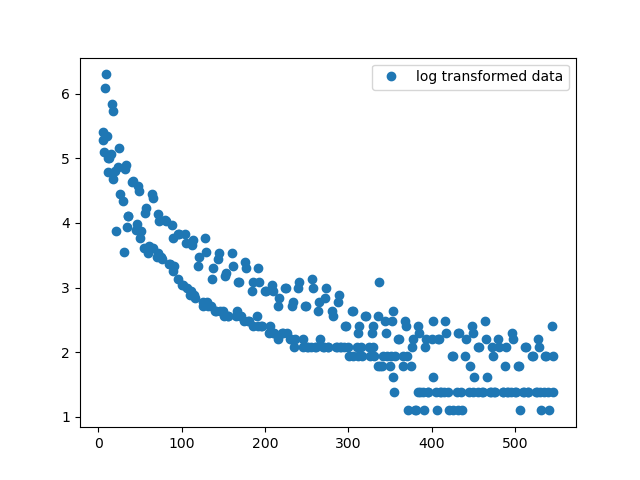

In [ ]:
#| hide 

fig, ax = plt.subplots()
#ax.plot(x,y, 'o', label='resampled data')
ax.plot(x,y_log, 'o', label = 'log transformed data')
#ax.plot(xs, cs(xs), label = 'spline')
#ax.plot(xs, cs(xs,1), label = "S '")
#ax.plot(xs, cs(xs,2), label = "S ''")

ax.legend(loc = 'upper right', ncol=2);

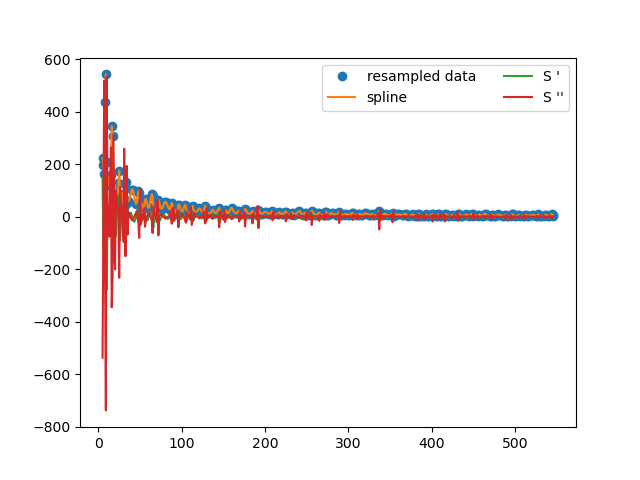

In [ ]:
#| hide
fig, ax = plt.subplots()
ax.plot(x,y, 'o', label='resampled data')
ax.plot(xs, cs(xs), label = 'spline')
ax.plot(xs, cs(xs,1), label = "S '")
ax.plot(xs, cs(xs,2), label = "S ''")

ax.legend(loc = 'upper right', ncol=2);

## variogram ? 

In [ ]:
#| hide
import skgstat as skg

In [ ]:
#| hide
coords = np.array(df['img_separation'])
values = np.array(df['v_error'])